In [1]:
using Catalyst, DifferentialEquations
using BlackBoxOptim
using CSV
using DataFrames
using DataStructures
using Statistics
using NaNStatistics
using Plots
using Latexify
include("IRFConvolution.jl")
include("DataImport.jl")
include("TypeDefinitions.jl")

## Define your kinetic model and parameter bounds
*Only edit this cell*

In [3]:
# import data
RealData = importData("/Users/jessicaflowers/Desktop/JULIA/data/BiVO4"; miss="NaN")

# define kinetic model
rs = @reaction_network begin
    k1, A --> 0
    k2, 2B --> 0
    k3, C --> 0
end
# odesys = convert(ODESystem, rs) # print the differential equations for this reaction system

# define bounds for the parameter optimization 
state_lower = [8, 3.5, 5.5] # A, B, C, ...
state_upper = [9, 4.5, 6.5] 

IRF_lower = [0.9, 0.009] # μ, σ
IRF_upper = [1.2, 0.2]

rate_const_lower = [1.2, 0.002, 0.00007] # k1, k2, k3, ...
rate_const_upper = [2, 0.003, 0.00008]

┌ Warning: `datarow` keyword argument is deprecated; use `skipto` instead
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/context.jl:352
┌ Warning: `type` keyword argument is deprecated; a single type can be passed to `types` instead
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/context.jl:356


┌ Error: Multi-threaded parsing failed (are there newlines inside quoted fields?), falling back to single-threaded parsing
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/context.jl:652
┌ Warning: thread = 1 warning: error parsing Float64 around row = 130, col = 1: "file info:Date: March 04,", error=INVALID: DELIMITED | INVALID_DELIMITER 
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/file.jl:580
┌ Warning: thread = 1 warning: only found 2 / 463 columns around data row: 130. Filling remaining columns with `missing`
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/file.jl:577
┌ Warning: thread = 1 warning: error parsing Float64 around row = 131, col = 1: "Sample: S2
│ ", error=INVALID: NEWLINE | INVALID_DELIMITER 
└ @ CSV /Users/jessicaflowers/.julia/packages/CSV/OnldF/src/file.jl:580
┌ Warning: thread = 1 warning: only found 1 / 463 columns around data row: 131. Filling remaining columns with `missing`
└ @ CSV /Users/jessicaflowers/.julia/packages/CS

3-element Vector{Float64}:
 2.0
 0.003
 8.0e-5

### Pre-processing of the input csv file

In [4]:
# Extract wavelength range and time vector, wavelength range is the first column and time vector is the first row
wavelength = RealData.x
wavelength = vcat(wavelength...)
time = RealData.y
time = vcat(time...)
Data = RealData.z
Data = (vcat(Data...))
Data = coalesce.(Data, NaN)


# create bounds array
lower = vcat(state_lower, IRF_lower, rate_const_lower)
upper = vcat(state_upper, IRF_upper, rate_const_upper)

bounds = Array{Tuple{Float64, Float64}}(undef,length(lower))
for k in 1:length(lower)
    bounds[k] = (lower[k], upper[k])
end

### Functions to extract spectral signatures and minimize difference to real data
- **GetData** takes a parameter vector as input, and returns a newly constructed 2D data matrix, kinetic traces, and spectral signatures based on the provided parameters.
- **Objective** takes the same parameter vector as input and returns the sum of squared differences between the newly constructed data and the real data. The Objective function is optimized to obtain the parameter vector that minimizes this difference most significantly.



In [5]:
"""
In order to simulate the kinetic model, there is information that needs to be provided to the simulator in a specific format:
    1. The initial condition, i.e. the amplitudes of each species/component at the begining of the simulation. This is given as a vector u0.
    2. Parameter values, i.e. the values of the rate constants. This is given as a vector p.
    3. Time span for which we run the simulation. 

Goals of the GetData function:
    1. Extract all necessary information from the kinetic model defined in the first cell, i.e., the rate constants (k1, k2,...) and components (A, B,...).
    2. Set up vectors u0 and p. 
        a. Create an empty dictionary of the symbolic representations for each component, i.e. key = A, value = []
        b. Do the same for the rate constants, i.e. key = k1, value = []
        b. Map the corresponding values from the input param vector onto the elements in your dictionaries, i.e key = A, value = param[1] = 1
    3. Simulate kinetic model and convolve the resulting kinetic traces in order to respresent the IRF.
    4. Gererate spectral signatures based on these kinetic traces and the real input data.
    5. Generate a simulated 2D data matrix based on the simulated kinetics and spectra.
"""


function GetData(param) # A, B, ..., μ, σ, k1, k2, k3
    # Extract the number of states/components and rate constants from the kinetic model
    num_states = length(states(rs)) # number of components
    num_k = length(Catalyst.parameters(rs)) # number of rate constants
    States = states(rs) # get components from kinetic model, A(t), B(t), C(t) ...

    u0_ = OrderedDict{Symbol, Float64}() # initialize dictionary for the component amplitudes
    for (i, state) in enumerate(States) # loop through the components A, B ... extracted from kinetic model
        name = string(state)
        name = match(r"(\w+)", name).captures[1]  # Extract alphanumeric part of the name, i.e. A rather than A(t)
        u0_[Symbol(name)] = param[i] # map the values from param onto their corresponding symbolic representations in u0_ dictionary 
    end
    # convert u0_ dictionary into u0 vector
    u0 = Pair{Symbol, Float64}[] 
    for (key, value) in pairs(u0_)
        push!(u0, Pair(key, Float64(value))) 
    end
    u0 = collect(u0) # collect initial amplitude vector (this will be mapped onto the states A, B, ...) 

    num_p = num_states + num_k + 2 # the number of parameters to optimize is the number of states + rate constants + μ + σ
    k_start = num_states + 3 # rate constants in parameter vector start after the states and μ and σ, i.e. num_states + 3
    unsorted_k = ((param[k_start:num_p])) # rate constants, unsorted

    
    Ks = Catalyst.parameters(rs) # get the rate constants from the kinetic model, k1, k2, k3
    p_ = OrderedDict{Symbol, Float64}() # set up dictionary for the rate constants

    for (i, K) in enumerate(Ks) # loop through rate constants extracted from kinetic model
        rate_const = string(K)
        p_[Symbol(rate_const)] = unsorted_k[i] # map the values from param onto their corresponding symbolic representations in p_ dictionary
    end
    # convert p_ dictionary to p vector
    p = Pair{Symbol, Float64}[]
    for (key, value) in pairs(p_)
        push!(p, Pair(key, Float64(value)))
    end
    collect(p) # collect rate constants into vector

    # IRF parameters
    μ=param[num_states+1] # the first IRF parameter is after the component amplitudes, i.e. after num_states
    σ=param[num_states+2]

    # set up time span for the simulation of the kinetic model
    TimeODE, TimeIRFPos, IRFWindowCut, TimeODEBool = defineIRFTime(time, μ, σ)
    tspan = [minimum(TimeODE),maximum(TimeODE)] 

    # simulate the kinetics
    prob = ODEProblem(rs, u0, tspan, p; saveat=TimeODE)
    sol  = solve(prob, Tsit5())
    sol_array = Array(sol)

    # Perform convolution for each component
    ConvKin = Vector{Array{Float64,1}}(undef, num_states)
    for i in 1:num_states # loop through components
        component = sol_array[i,:]
        ConvKin[i] = convolveIRF(time, component, μ, σ, TimeIRFPos, IRFWindowCut, TimeODEBool)
    end

    simKin = reduce(vcat, ConvKin')  # kinetic matrix
    simSpec = Data / simKin  # spectral signatures matrix
    simData = simSpec * simKin # test matrix from kinetics and signatures
    return simData, simSpec, simKin
end


GetData (generic function with 1 method)

In [6]:
"""
Goals of Objective function:
    1. Read the simulated data matrix from GetData.
    2. Compare simulated data to real data and return the sum of squared differneces. 
    3. Return a "residual map", if specified by the user. 
"""

function Objective(param; output="res")
    da = GetData(param) 
    simData = da[1] # get the simulated data from GetData
    if output == "res"
        return nansum((simData .- Data).^2) # sum of squared differences
    elseif output == "map" # return a residuals map
        return Plots.heatmap(time, wavelength, (simData - Data), xlabel="Time", ylabel="Wavelength", 
                    title="Residuals Map", colorbar_title="\n \n \n Δ Absorbance", 
                    right_margin=15Plots.mm, left_margin=10Plots.mm, xguidefontsize=10, yguidefontsize=10)
    end
end

Objective (generic function with 1 method)

### OP function runs an optimization algorithm which aims to minimize the Objective function. 
- It works by finding a parameter vector which results in the smalles possible sum of squared difference (between simulated and real data)
- Takes the upper/lower bounds specified in the first cell as input

In [7]:
OP = bboptimize(Objective; SearchRange = bounds)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 51 evals, 26 steps

, improv/step: 0.654 (last = 0.6538), fitness=0.006593086


1.02 secs, 129 evals, 77 steps, improv/step: 0.545 (last = 0.4902), fitness=0.006570424
1.52 secs, 231 evals, 160 steps

, improv/step: 0.581 (last = 0.6145), fitness=0.006516060


2.02 secs, 311 evals, 231 steps, improv/step: 0.502 (last = 0.3239), fitness=0.006516060
2.52 secs, 389 evals, 301 steps

, improv/step: 0.488 (last = 0.4429), fitness=0.006516060


3.02 secs, 473 evals, 384 steps, improv/step: 0.464 (last = 0.3735), fitness=0.006516060
3.53 secs, 574 evals, 485 steps

, improv/step: 0.456 (last = 0.4257), fitness=0.006512048


4.03 secs, 684 evals, 595 steps, improv/step: 0.471 (last = 0.5364), fitness=0.006508171
4.53 secs, 791 evals, 702 steps

, improv/step: 0.452 (last = 0.3458), fitness=0.006504673


5.03 secs, 894 evals, 805 steps, improv/step: 0.448 (last = 0.4272), fitness=0.006504348
5.53 secs, 1000 evals, 911 steps

, improv/step: 0.448 (last = 0.4434), fitness=0.006503175


6.04 secs, 1102 evals, 1013 steps, improv/step: 0.431 (last = 0.2843), fitness=0.006503175
6.54 secs, 1201 evals, 1112 steps

, improv/step: 0.429 (last = 0.4040), fitness=0.006501679


7.04 secs, 1313 evals, 1224 steps, improv/step: 0.421 (last = 0.3393), fitness=0.006501294
7.54 secs, 1425 evals, 1336 steps

, improv/step: 0.424 (last = 0.4643), fitness=0.006498996


8.04 secs, 1535 evals, 1446 steps, improv/step: 0.420 (last = 0.3636), fitness=0.006498610
8.55 secs, 1651 evals, 1562 steps

, improv/step: 0.419 (last = 0.4052), fitness=0.006497909


9.05 secs, 1744 evals, 1655 steps, improv/step: 0.418 (last = 0.4086), fitness=0.006497909
9.55 secs, 1839 evals, 1750 steps

, improv/step: 0.418 (last = 0.4105), fitness=0.006497207


10.05 secs, 1946 evals, 1857 steps, improv/step: 0.414 (last = 0.3458), fitness=0.006497207
10.56 secs, 2064 evals, 1975 steps

, improv/step: 0.411 (last = 0.3644), fitness=0.006497028


11.06 secs, 2185 evals, 2096 steps, improv/step: 0.405 (last = 0.3058), fitness=0.006497028
11.56 secs, 2302 evals, 2213 steps

, improv/step: 0.405 (last = 0.4188), fitness=0.006497028


12.07 secs, 2420 evals, 2331 steps, improv/step: 0.404 (last = 0.3814), fitness=0.006496933
12.58 secs, 2538 evals, 2449 steps

, improv/step: 0.405 (last = 0.4153), fitness=0.006496919


13.08 secs, 2645 evals, 2556 steps, improv/step: 0.403 (last = 0.3645), fitness=0.006496816
13.58 secs, 2754 evals, 2665 steps

, improv/step: 0.400 (last = 0.3394), fitness=0.006496793


14.08 secs, 2862 evals, 2773 steps, improv/step: 0.401 (last = 0.4074), fitness=0.006496772
14.59 secs, 2981 evals, 2892 steps

, improv/step: 0.400 (last = 0.3950), fitness=0.006496771


15.09 secs, 3100 evals, 3011 steps, improv/step: 0.398 (last = 0.3445), fitness=0.006496719
15.59 secs, 3218 evals, 3129 steps

, improv/step: 0.399 (last = 0.4322), fitness=0.006496699


16.10 secs, 3337 evals, 3248 steps, improv/step: 0.402 (last = 0.4706), fitness=0.006496626
16.60 secs, 3455 evals, 3366 steps

, improv/step: 0.403 (last = 0.4237), fitness=0.006496616


17.10 secs, 3573 evals, 3484 steps, improv/step: 0.404 (last = 0.4407), fitness=0.006496591
17.61 secs, 3695 evals, 3606 steps

, improv/step: 0.404 (last = 0.4016), fitness=0.006496586


18.11 secs, 3816 evals, 3727 steps, improv/step: 0.405 (last = 0.4380), fitness=0.006496583
18.61 secs, 3937 evals, 3848 steps

, improv/step: 0.404 (last = 0.3554), fitness=0.006496578


19.11 secs, 4058 evals, 3969 steps, improv/step: 0.404 (last = 0.4050), fitness=0.006496571
19.61 secs, 4179 evals, 4090 steps

, improv/step: 0.402 (last = 0.3554), fitness=0.006496571


20.11 secs, 4298 evals, 4209 steps, improv/step: 0.402 (last = 0.3782), fitness=0.006496571
20.61 secs, 4418 evals, 4329 steps

, improv/step: 0.399 (last = 0.3000), fitness=0.006496570


21.12 secs, 4540 evals, 4451 steps, improv/step: 0.398 (last = 0.3770), fitness=0.006496569
21.62 secs, 4661 evals, 4572 steps

, improv/step: 0.396 (last = 0.3223), fitness=0.006496566


22.12 secs, 4780 evals, 4691 steps, improv/step: 0.394 (last = 0.3277), fitness=0.006496564
22.62 secs, 4889 evals, 4800 steps

, improv/step: 0.393 (last = 0.3394), fitness=0.006496564


23.12 secs, 4995 evals, 4906 steps, improv/step: 0.393 (last = 0.3774), fitness=0.006496563
23.63 secs, 5110 evals, 5021 steps

, improv/step: 0.394 (last = 0.4348), fitness=0.006496563


24.13 secs, 5233 evals, 5144 steps, improv/step: 0.392 (last = 0.3415), fitness=0.006496563
24.63 secs, 5353 evals, 5264 steps

, improv/step: 0.392 (last = 0.3833), fitness=0.006496562


25.14 secs, 5463 evals, 5374 steps, improv/step: 0.393 (last = 0.4364), fitness=0.006496562
25.64 secs, 5560 evals, 5471 steps

, improv/step: 0.394 (last = 0.4124), fitness=0.006496562


26.14 secs, 5651 evals, 5562 steps, improv/step: 0.393 (last = 0.3846), fitness=0.006496562
26.65 secs, 5763 evals, 5674 steps

, improv/step: 0.392 (last = 0.3482), fitness=0.006496561


27.15 secs, 5877 evals, 5788 steps, improv/step: 0.391 (last = 0.3421), fitness=0.006496561
27.65 secs, 5991 evals, 5902 steps

, improv/step: 0.391 (last = 0.3596), fitness=0.006496561


28.15 secs, 6108 evals, 6019 steps, improv/step: 0.391 (last = 0.4188), fitness=0.006496561
28.65 secs, 6224 evals, 6135 steps

, improv/step: 0.392 (last = 0.4052), fitness=0.006496561


29.16 secs, 6336 evals, 6247 steps, improv/step: 0.392 (last = 0.4107), fitness=0.006496561
29.66 secs, 6439 evals, 6350 steps

, improv/step: 0.392 (last = 0.3786), fitness=0.006496561


30.16 secs, 6541 evals, 6452 steps, improv/step: 0.391 (last = 0.3431), fitness=0.006496561
30.66 secs, 6656 evals, 6567 steps

, improv/step: 0.392 (last = 0.4348), fitness=0.006496561


31.16 secs, 6751 evals, 6662 steps, improv/step: 0.392 (last = 0.4105), fitness=0.006496561
31.66 secs, 6864 evals, 6775 steps

, improv/step: 0.391 (last = 0.3540), fitness=0.006496561


32.16 secs, 6978 evals, 6889 steps, improv/step: 0.392 (last = 0.4474), fitness=0.006496561
32.67 secs, 7095 evals, 7006 steps

, improv/step: 0.392 (last = 0.3504), fitness=0.006496561


33.17 secs, 7210 evals, 7121 steps, improv/step: 0.390 (last = 0.2957), fitness=0.006496561
33.68 secs, 7316 evals, 7227 steps

, improv/step: 0.390 (last = 0.3679), fitness=0.006496561


34.19 secs, 7418 evals, 7329 steps, improv/step: 0.391 (last = 0.4412), fitness=0.006496561
34.69 secs, 7528 evals, 7439 steps

, improv/step: 0.390 (last = 0.3364), fitness=0.006496561


35.19 secs, 7639 evals, 7550 steps, improv/step: 0.388 (last = 0.3063), fitness=0.006496561
35.69 secs, 7753 evals, 7664 steps

, improv/step: 0.388 (last = 0.3421), fitness=0.006496561


36.19 secs, 7858 evals, 7769 steps, improv/step: 0.387 (last = 0.3524), fitness=0.006496561
36.70 secs, 7971 evals, 7882 steps

, improv/step: 0.389 (last = 0.4779), fitness=0.006496561


37.20 secs, 8072 evals, 7983 steps, improv/step: 0.389 (last = 0.4059), fitness=0.006496561
37.70 secs, 8176 evals, 8087 steps

, improv/step: 0.390 (last = 0.4423), fitness=0.006496561


38.20 secs, 8287 evals, 8198 steps, improv/step: 0.389 (last = 0.3874), fitness=0.006496561
38.70 secs, 8401 evals, 8312 steps

, improv/step: 0.389 (last = 0.3509), fitness=0.006496561


39.20 secs, 8512 evals, 8423 steps, improv/step: 0.388 (last = 0.3243), fitness=0.006496561
39.71 secs, 8611 evals, 8522 steps

, improv/step: 0.387 (last = 0.3131), fitness=0.006496561


40.21 secs, 8716 evals, 8627 steps, improv/step: 0.386 (last = 0.3238), fitness=0.006496561
40.72 secs, 8829 evals, 8740 steps

, improv/step: 0.387 (last = 0.4425), fitness=0.006496561


41.22 secs, 8916 evals, 8827 steps, improv/step: 0.387 (last = 0.3563), fitness=0.006496561
41.73 secs, 9033 evals, 8944 steps

, improv/step: 0.387 (last = 0.4017), fitness=0.006496561


42.23 secs, 9146 evals, 9057 steps, improv/step: 0.386 (last = 0.3186), fitness=0.006496561
42.73 secs, 9250 evals, 9161 steps

, improv/step: 0.387 (last = 0.4327), fitness=0.006496561


43.24 secs, 9355 evals, 9266 steps, improv/step: 0.386 (last = 0.2857), fitness=0.006496561
43.74 secs, 9461 evals, 9372 steps

, improv/step: 0.385 (last = 0.3302), fitness=0.006496561


44.24 secs, 9566 evals, 9477 steps, improv/step: 0.385 (last = 0.4000), fitness=0.006496561
44.74 secs, 9676 evals, 9587 steps

, improv/step: 0.385 (last = 0.3909), fitness=0.006496561


45.24 secs, 9778 evals, 9689 steps, improv/step: 0.385 (last = 0.3725), fitness=0.006496561
45.74 secs, 9888 evals, 9799 steps

, improv/step: 0.385 (last = 0.3364), fitness=0.006496561


46.25 secs, 10000 evals, 9911 steps, improv/step: 0.385 (last = 0.4196), fitness=0.006496561

Optimization stopped after 10001 steps and 46.70 seconds


Termination reason: Max number of steps (10000) reached
Steps per second = 214.16
Function evals per second = 216.07
Improvements/step = 0.38510
Total function evaluations = 10090


Best candidate found: 

[8.9971, 4.5, 5.67569, 0.925641, 0.2, 2.0, 0.003, 8.0e-5]

Fitness: 0.006496561



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (10000) reached", 10001, 1.69204852126006e9, 46.69804883003235, ParamsDictChain[ParamsDictChain[Dict{Symbol, Any}(:RngSeed => 312959, :SearchRange => [(8.0, 9.0), (3.5, 4.5), (5.5, 6.5), (0.9, 1.2), (0.009, 0.2), (1.2, 2.0), (0.002, 0.003), (7.0e-5, 8.0e-5)], :MaxSteps => 10000),Dict{Symbol, Any}()],Dict{Symbol, Any}(:CallbackInterval => -1.0, :TargetFitness => nothing, :TraceMode => :compact, :FitnessScheme => ScalarFitnessScheme{true}(), :MinDeltaFitnessTolerance => 1.0e-50, :NumDimensions => :NotSpecified, :FitnessTolerance => 1.0e-8, :TraceInterval => 0.5, :MaxStepsWithoutProgress => 10000, :MaxSteps => 10000…)], 10090, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64, Vector{Float64}}(0.006496560912065654, [8.997097960513898, 4.499999998622548, 5.675692585696272, 0.9256414086241918, 0.19999999974849517, 1.9999999982445869, 0.0029999999991356693, 7.99999993009556e-5

## Data processing and plotting

In [8]:
RecoveredParam = best_candidate(OP) # recover optimized parameter vector 
RecoveredData = GetData(RecoveredParam) # plug optimized parameters into GetData
DataMatrix = RecoveredData[1] # data matrix
RecoveredSpec = RecoveredData[2] # spectral signatures
RecoveredKinetics = RecoveredData[3] # kinetic

3×462 Matrix{Float64}:
  1.93145e-16  2.49768e-16   1.41382e-16  …  -7.80324e-8  1.06186e-7
  8.6212e-16   4.46776e-16   2.22968e-16      0.109285    0.10875
 -1.59748e-17  1.57161e-17  -2.22968e-16      4.47321     4.46785

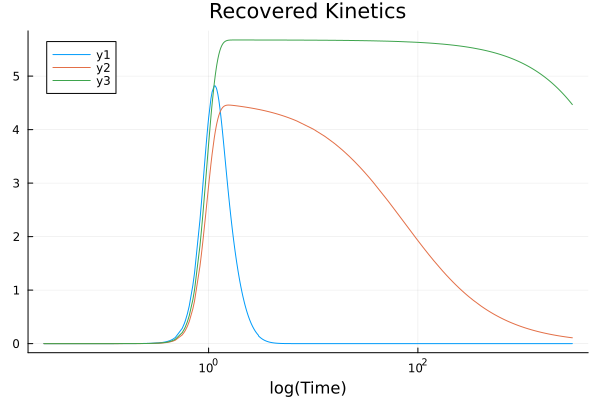

In [9]:
# kinetics
tpos = time.>0
Plots.plot(time[tpos], RecoveredKinetics[1,:][tpos], xscale=:log10,
     title="Recovered Kinetics", xlabel="log(Time)", legend=:topleft)
Plots.plot!(time[tpos], RecoveredKinetics[2,:][tpos], xscale=:log10)
Plots.plot!(time[tpos], RecoveredKinetics[3,:][tpos], xscale=:log10)


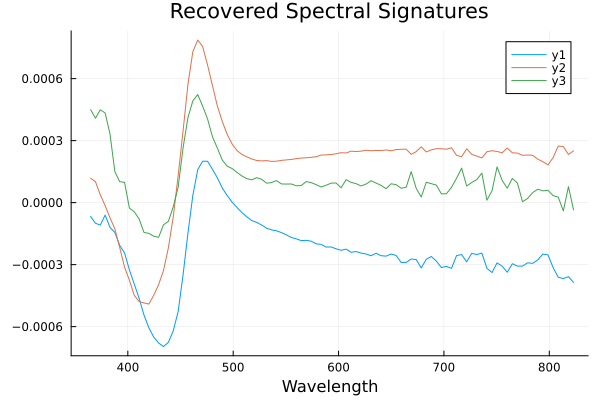

In [10]:
# spectral signatures
Plots.plot(wavelength, RecoveredSpec, title="Recovered Spectral Signatures", xlabel="Wavelength") 

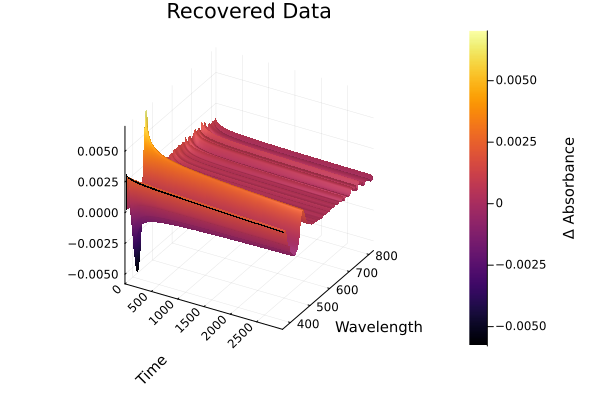

In [11]:
# 3D recovered data 
Plots.surface(time, wavelength, DataMatrix, title="Recovered Data", xlabel="Time", ylabel="         Wavelength", xguidefontsize=10, yguidefontsize=10, xrotation = 45, right_margin=15Plots.mm, colorbar_title="\n\n\n\nΔ Absorbance")


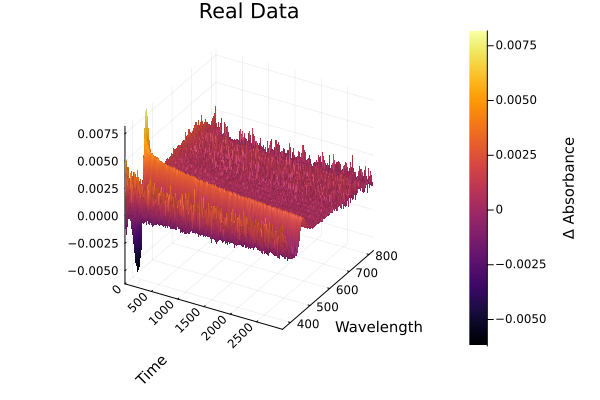

In [12]:
# 3D Real data
Plots.surface(time, wavelength, Data, title="Real Data", xlabel="Time", ylabel="         Wavelength", xguidefontsize=10, yguidefontsize=10, xrotation = 45, right_margin=15Plots.mm, colorbar_title="\n\n\n\nΔ Absorbance")


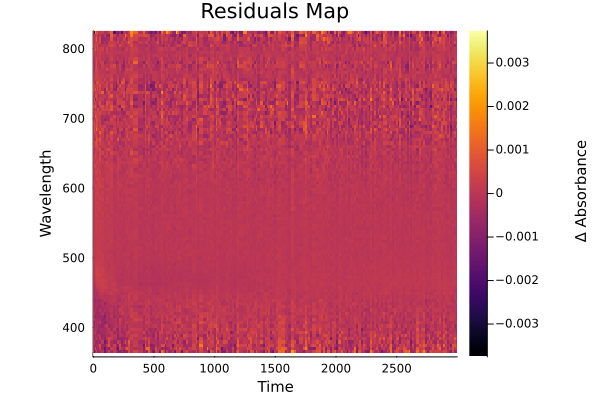

In [13]:
# residual maps 
map = Objective(RecoveredParam; output="map")

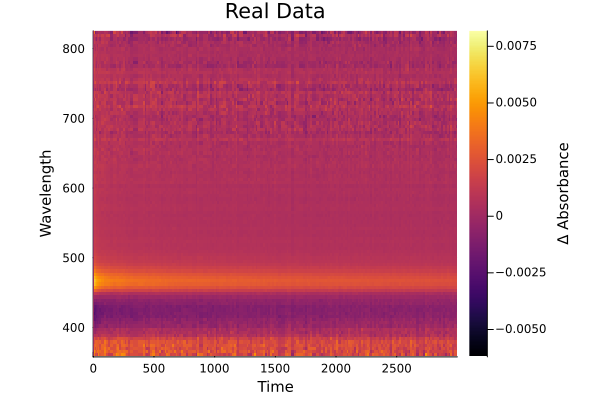

In [14]:
# heatmap of real data
real_heatmap = Plots.heatmap(time, wavelength, Data, xlabel="Time", ylabel="Wavelength", title="Real Data", colorbar_title="\n\nΔ Absorbance", right_margin=15Plots.mm, left_margin=10Plots.mm, xguidefontsize=10, yguidefontsize=10)


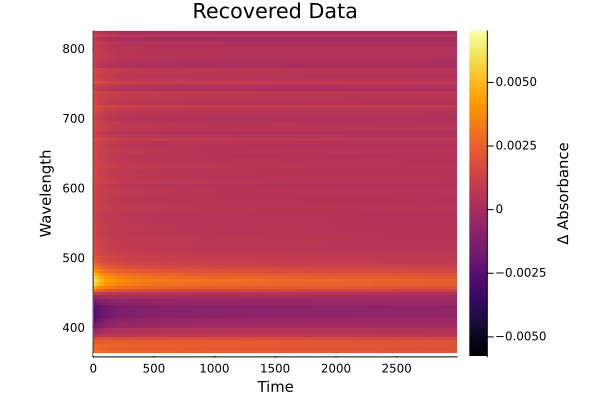

In [15]:
# heatmap of recovered data
optim_heatmap = Plots.heatmap(time, wavelength, DataMatrix, xlabel="Time", ylabel="Wavelength", title="Recovered Data" ,colorbar_title="\n\nΔ Absorbance", right_margin=15Plots.mm, left_margin=10Plots.mm, xguidefontsize=10, yguidefontsize=10)
